In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2425)

## Data generation

In [2]:
# Good, but 2 CLASSES ONLY
#   alpha increases "spread"
#   beta increases "jitter"
def generate_data(n, alpha=0.1, beta=1, initial_point=[0, 0], groups=[0, 1], add_bias=True):
    data = np.empty((n, 2))
    # Define an initial point
    data[0, :] = initial_point
    
    # Randomly "scale" the upcoming reflection
    a = np.random.uniform(low=(-1-alpha), high=(-1+alpha), size=n)
    
    # "Flip" previous point and add some noise
    for k in range(1, n):
        data[k, ] = a[k]*data[k-1, :] + beta*np.random.normal(0, 1, size=2)
    
    # Add a bias variable
    if add_bias:
        data = np.hstack((np.ones((n, 1)), data))
    
    # Labels are two classes (0, 1), strictly alternating, because of "flipping" above
    labs = np.array(groups*(n//2 + 1))[:n]
    
    return data, labs

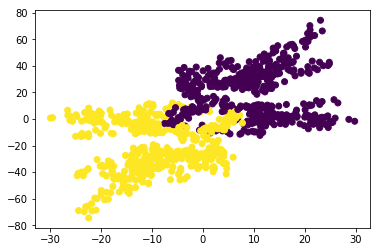

In [3]:
demo_data, demo_labs = generate_data(1000, initial_point=[10, 10])

plt.scatter(demo_data[:, 1], demo_data[:, 2], c=demo_labs)

## Auxiliary functions

In [4]:
def make_sets(data, labels, props, shuffle=True):
    
    if sum(props) != 1:
        raise ValueError("proportions must sum to 1")
    
    m = data.shape[0]
    idx = np.random.permutation(m) if shuffle else range(m)
    
    sets = []
    cursor = 0
    
    for p in props:
        dset = data[idx, :][cursor:(cursor+int(p*m)), :]
        sets.append(dset)
        lset = labels[idx][cursor:(cursor+int(p*m))]
        sets.append(lset)
        
        cursor = int(p*m)
    
    return sets

In [5]:
X_train, y_train, X_val, y_val, X_test, y_test = make_sets(demo_data, demo_labs, [0.6, 0.2, 0.2])

In [6]:
X_train.shape

(600, 3)

In [7]:
y_val.shape

(200,)

In [8]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [9]:
sigmoid(1)

0.7310585786300049

In [10]:
def predict(features, weights):
    Z = np.dot(features, weights)
    return sigmoid(Z)

In [11]:
# Must initialise weights to be different
# Otherwise complete cancellation can lead to failure
init_weights = np.random.uniform(-0.1, 0.1, 3)

In [12]:
pp = predict(X_train, init_weights)
pp.shape, pp.sum()

((600,), 301.9140243759815)

In [13]:
def classify(predictions, threshold=0.5):
    return (predictions >= threshold).astype(int)

In [14]:
classify(pp)[:10]

array([1, 0, 0, 0, 1, 0, 0, 0, 1, 1])

In [15]:
def accuracy(predicted, actual):
    return np.mean(predicted == actual)

In [16]:
def plot_boundary(data, labels, weights, subdivs=200, alpha=0.2):
    
    fig, ax = plt.subplots()
    ax.scatter(data[:, 1], data[:, 2], c=labels)
    
    xmin, xmax = ax.get_xlim()
    xstep = (xmax-xmin)/subdivs
    ymin, ymax = ax.get_ylim()
    ystep = (ymax-ymin)/subdivs
    
    grid = np.mgrid[xmin:xmax:xstep, ymin:ymax:ystep].reshape(2, -1).T
    n = grid.shape[0]
    grid_with_bias = np.hstack((np.ones((n, 1)), grid))
    
    ax.contourf(np.arange(xmin, xmax, xstep), np.arange(ymin, ymax, ystep),
               predict(grid_with_bias, weights).reshape(-1, subdivs).T,
               alpha = alpha)
    
    ax.scatter(data[:, 1], data[:, 2], c=labels)
    return None

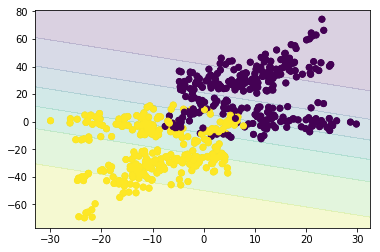

In [17]:
plot_boundary(X_train, y_train, init_weights)

## Simple logistic regression

In [18]:
def get_cost(features, labels, weights):
    
    m = features.shape[0]
    preds = predict(features, weights)
    
    # Log-loss cost function
    cost = -(labels*np.log(preds) + (1-labels)*np.log(1-preds)).sum()
    
    # Average cost per observation
    return cost/m
    

In [19]:
get_cost(X_train, y_train, init_weights)

0.3468848459825562

In [20]:
def get_grad(features, labels, weights):
    
    m = features.shape[0]
    preds = predict(features, weights)
    
    # Average gradient over all observations
    grad = np.dot(features.T, (preds - labels)) / m
    
    return grad

In [21]:
get_grad(X_train, y_train, init_weights)

array([0.00652337, 2.00053475, 3.23295849])

In [22]:
# gamma is for regularisation - soon!
def train(features, labels, init_weights, iters=1000, rate=0.1, tolerance=1e-6, verbose=True, report_level=100):

    cost = get_cost(features, labels, init_weights)
    
    if verbose:
        print("Training in progress...")
        print("")
        print("Iter | Cost")
        print("---- | ----")
        print("0000 |", cost)

    cost_history = np.empty(iters+1)
    cost_history[0] = cost
    weights = init_weights[:]
    
    for k in range(1, iters+1):
        
        # Update weights based on gradient of cost function
        grad = get_grad(features, labels, weights)
        weights = weights - rate*grad
        
        new_cost = get_cost(features, labels, weights)
        
        # Stopping criterion
        if abs(cost - new_cost) < tolerance:
            if verbose:
                print("Tolerance reached - terminating early!")
            
            cost_history = cost_history[:k]
            break
            
        else:        
            cost = new_cost
            cost_history[k] = cost
        
            if verbose and k % report_level == 0:
                print(str(k).zfill(4), "|", cost)
    
    if verbose:
        print("")
        print("Training complete!")
        print("Iterations completed:", k)
        print("Final cost:", cost_history[-1])
    
    return weights, cost_history

In [23]:
optw, ch = train(X_train, y_train, init_weights, rate=0.01, iters=2000, report_level=10)

Training in progress...

Iter | Cost
---- | ----
0000 | 0.3468848459825562
0010 | 0.173345943420615
0020 | 0.16190461403622777
0030 | 0.15821423304255522
0040 | 0.1566565764036577
0050 | 0.15590989669322847
0060 | 0.15552476149235428
0070 | 0.15531663389630118
0080 | 0.15520056217928901
0090 | 0.15513437643565609
0100 | 0.15509602148047613
0110 | 0.15507352328110605
0120 | 0.15506020095400255
Tolerance reached - terminating early!

Training complete!
Iterations completed: 121
Final cost: 0.15506020095400255


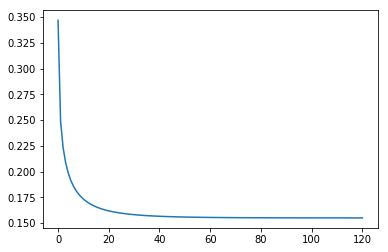

In [24]:
plt.plot(ch)

In [25]:
optw

array([ 0.04952156, -0.19769644, -0.15890006])

In [26]:
preds = predict(X_val, optw)
preds_classes = classify(preds)

accuracy(preds_classes, y_val)

0.945

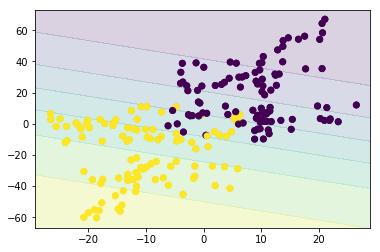

In [27]:
plot_boundary(X_val, y_val, init_weights)

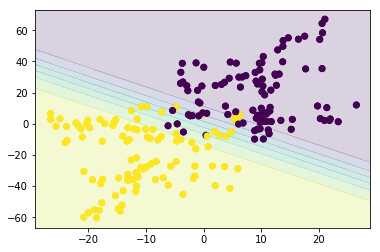

In [28]:
plot_boundary(X_val, y_val, optw)

## Regularisation

Large weights increase sensitivity of output to small changes in input. Better if we can "spread" this sensitivity over the weights, to reduce reliance on any individual weights, thus improving robustness (and hopefully improving generalisation).

Discourage large weights by adding a penalty term to the cost function: (squared) L2-norm of all weights.

In [60]:
def get_cost(features, labels, weights, gamma):
    
    m = features.shape[0]
    preds = predict(features, weights)
    
    # Log-loss cost function
    cost = -(labels*np.log(preds) + (1-labels)*np.log(1-preds)).sum()
    
    # Add regularisation term
    cost = cost + (gamma/2)*(weights[1:]**2).sum()
    
    # Average cost per observation
    return cost/m
    

In [61]:
get_cost(X_train, y_train, init_weights, 100)

0.3470919325813512

In [62]:
def get_grad(features, labels, weights, gamma):
    
    m = features.shape[0]
    preds = predict(features, weights)
    
    # Gradient of cost function
    grad = np.dot(features.T, (preds - labels))
    
    # Add gradient of regularisation term
    regs = gamma*weights
    regs[0] = 0
    grad = grad + regs
    
    # Average grad per observation
    return grad/m

In [63]:
get_grad(X_train, y_train, init_weights, 100)

array([0.00652337, 1.99631072, 3.22580402])

Likely there will be virtually no difference here, but we'll see the effect once we have more dimensions...

## Variable step size

Two approaches:

* Decrease at a set rate (e.g. exponential decay)
* Adaptive decrease (e.g. backtracking)

Second approach is perhaps more expensive, but mitigated if we assume that step size **decreases** as we approach the optimum. Offers more flexibility.

In [64]:
# Added gamma
# Added backtracking for step size
def train(features, labels, init_weights, iters=1000, rate=0.1, gamma=0, tolerance=1e-6, verbose=True, report_level=100):

    cost = get_cost(features, labels, init_weights, gamma)
    
    if verbose:
        print("Training in progress...")
        print("")
        print("Iter | Cost")
        print("---- | ----")
        print("0000 |", cost)

    cost_history = np.empty(iters+1)
    cost_history[0] = cost
    weights = init_weights[:]
    
    for k in range(1, iters+1):
        
        # Update weights based on gradient of cost function
        grad = get_grad(features, labels, weights, gamma)
        
        new_weights = weights - rate*grad
        new_cost = get_cost(features, labels, new_weights, gamma)
        
        while np.isnan(new_cost) or new_cost > cost:
            if verbose:
                print("  Rate change!", rate, "->", rate/2)
            rate = rate/2
            new_weights = weights - rate*grad
            new_cost = get_cost(features, labels, new_weights, gamma)
        
        rate = rate*1.1
        weights = new_weights
        
        # Stopping criterion
        if abs(cost - new_cost) < tolerance:
            if verbose:
                print("Tolerance reached - terminating early!")
            
            cost_history = cost_history[:k]
            break
            
        else:        
            cost = new_cost
            cost_history[k] = cost
        
            if verbose and k % report_level == 0:
                print(str(k).zfill(4), "|", cost)
    
    if verbose:
        print("")
        print("Training complete!")
        print("Iterations completed:", k)
        print("Final cost:", cost_history[-1])
    
    return weights, cost_history

In [65]:
optw, ch = train(X_train, y_train, init_weights, rate=1, gamma=100, iters=2000, report_level=2)

Training in progress...

Iter | Cost
---- | ----
0000 | 0.3470919325813512
  Rate change! 1 -> 0.5
  Rate change! 0.5 -> 0.25
  Rate change! 0.25 -> 0.125
  Rate change! 0.125 -> 0.0625
0002 | 0.17171559845499207
0004 | 0.16329357552096554
0006 | 0.16063810889936606
0008 | 0.16025814734284988
0010 | 0.1602420762495648
Tolerance reached - terminating early!

Training complete!
Iterations completed: 11
Final cost: 0.1602420762495648


C:\Users\ojones\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\Users\ojones\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


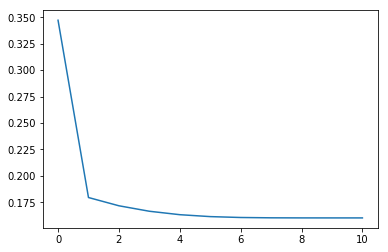

In [66]:
plt.plot(ch)

Note sharper elbow in plot (as a result of adaptive rate).

For now, we don't see much adaptation _during_ training... though it means we don't have to be quite so careful with our initial rate (we can just set it "too high" and let the backtracking work its way back down).

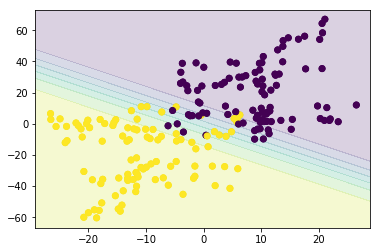

In [67]:
plot_boundary(X_val, y_val, optw)

In [68]:
preds = predict(X_val, optw)

In [69]:
preds_classes = classify(preds)
accuracy(preds_classes, y_val)

0.945

In [80]:
gammas = [0.1, 0.3, 1, 3, 10, 30, 100, 300, 100000]
costs = []
accs = []

for gamma in gammas:
    print("gamma:", gamma)
    optw, ch = train(X_train, y_train, init_weights, rate=1, gamma=gamma, iters=2000, verbose=False)
    preds = predict(X_val, optw)
    preds_classes = classify(preds)
    accs.append(accuracy(preds_classes, y_val))
    costs.append(ch[-1])

gamma: 0.1
gamma: 0.3
gamma: 1
gamma: 3
gamma: 10
gamma: 30
gamma: 100
gamma: 300
gamma: 100000


C:\Users\ojones\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\Users\ojones\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


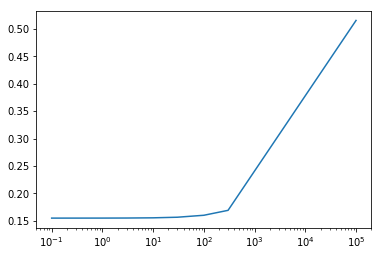

In [81]:
plt.plot(gammas, costs)
plt.xscale("log")

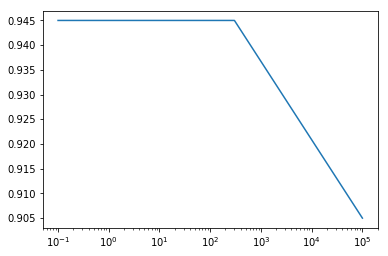

In [82]:
plt.plot(gammas, accs)
plt.xscale("log")

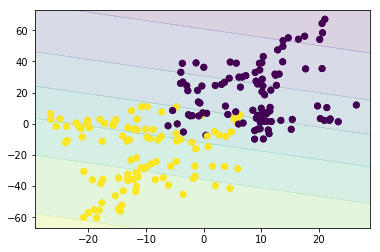

In [83]:
plot_boundary(X_val, y_val, optw)

## Generating higher-dimensional problems

Choose negative/positive range - all positive leads to potentially all obs on one side of boundary.

In [323]:
m = 500
d = 100

X = np.random.randn(m,d)# (-1, 1, size=(m, d))

In [290]:
X.shape

(100, 100)

In [291]:
gamma = 0.5
w = np.random.normal(0, gamma**2, size=d)
#w = np.random.multivariate_normal(np.zeros(d),gamma**2*np.identity(d))

In [292]:
w.shape

(100,)

In [293]:
mu = sigmoid(np.dot(X, w))

In [294]:
mu.shape

(100,)

(array([ 2.,  2.,  5., 19., 24., 25., 14.,  5.,  3.,  1.]),
 array([-6.37415235, -5.05861413, -3.74307592, -2.42753771, -1.11199949,
         0.20353872,  1.51907694,  2.83461515,  4.15015336,  5.46569158,
         6.78122979]),
 <a list of 10 Patch objects>)

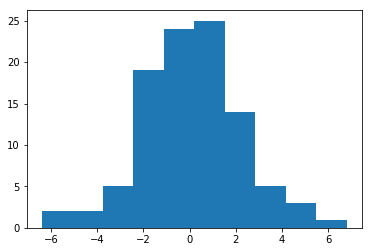

In [295]:
plt.hist(np.dot(X, w))

(array([12., 14.,  7.,  8.,  8.,  7.,  7., 11., 12., 14.]),
 array([0.00170216, 0.10141859, 0.20113501, 0.30085144, 0.40056786,
        0.50028429, 0.60000071, 0.69971713, 0.79943356, 0.89914998,
        0.99886641]),
 <a list of 10 Patch objects>)

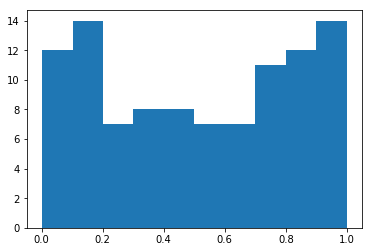

In [296]:
plt.hist(mu)

In [297]:
y = np.random.binomial(1, mu, size=m)

In [298]:
sum(y)

53

In [324]:
z=0.2*np.random.randn(d)

In [325]:
for i in range(50):
    X[i,:]=X[i,:]+z

In [326]:
y=np.concatenate((np.ones(50),np.zeros(50)))

In [327]:
X_train, y_train, X_val, y_val, X_test, y_test = make_sets(X, y, [0.6, 0.2, 0.2])

IndexError: index 365 is out of bounds for axis 0 with size 100

In [328]:
init_w = np.random.uniform(-0.1, 0.1, d)

In [329]:
optw, ch = train(X_train, y_train, init_w, rate=4, gamma=1, iters=5000, report_level=5)

Training in progress...

Iter | Cost
---- | ----
0000 | 0.5906219200133623
  Rate change! 4 -> 2.0
  Rate change! 2.0 -> 1.0
0005 | 0.10864293220969377
0010 | 0.08098655001606074
0015 | 0.0718716380402411
0020 | 0.06892254431808532
0025 | 0.06835542876549633
0030 | 0.06822244445087959
  Rate change! 21.1137767453526 -> 10.5568883726763
  Rate change! 11.61257720994393 -> 5.806288604971965
0035 | 0.06819401106448228
0040 | 0.06818392132941427
Tolerance reached - terminating early!

Training complete!
Iterations completed: 41
Final cost: 0.06818392132941427


C:\Users\ojones\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\Users\ojones\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


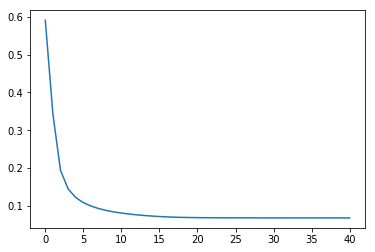

In [330]:
plt.plot(ch)

In [331]:
preds = predict(X_train, optw)
preds_classes = classify(preds)
accuracy(preds_classes, y_train)

1.0

In [332]:
preds = predict(X_val, optw)
preds_classes = classify(preds)

In [333]:
accuracy(preds_classes, y_val)

0.75

In [334]:
gammas = [0.00001, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300]
accs = []
final_costs = []

for gamma in gammas:
    print("Training with gamma=" + str(gamma))
    optw, ch = train(X_train, y_train, init_w, rate=4, gamma=gamma, iters=5000, report_level=1000)
    preds = predict(X_val, optw)
    preds_classes = classify(preds)
    accs.append(accuracy(preds_classes, y_val))
    final_costs.append(ch[-1])

Training with gamma=1e-05
Training in progress...

Iter | Cost
---- | ----
0000 | 0.5879301941543008
  Rate change! 4 -> 2.0
  Rate change! 2.0 -> 1.0
  Rate change! 1538.9933993880372 -> 769.4966996940186
  Rate change! 846.4463696634206 -> 423.2231848317103
Tolerance reached - terminating early!

Training complete!
Iterations completed: 79
Final cost: 4.082990005329206e-05
Training with gamma=0.01
Training in progress...

Iter | Cost
---- | ----
0000 | 0.5879570847645389
  Rate change! 4 -> 2.0
  Rate change! 2.0 -> 1.0
Tolerance reached - terminating early!

Training complete!
Iterations completed: 72
Final cost: 0.002824988384100854
Training with gamma=0.03
Training in progress...

Iter | Cost
---- | ----
0000 | 0.5880109198200707
  Rate change! 4 -> 2.0
  Rate change! 2.0 -> 1.0
Tolerance reached - terminating early!

Training complete!
Iterations completed: 65
Final cost: 0.006457484937223168
Training with gamma=0.1
Training in progress...

Iter | Cost
---- | ----
0000 | 0.588199

C:\Users\ojones\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\Users\ojones\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


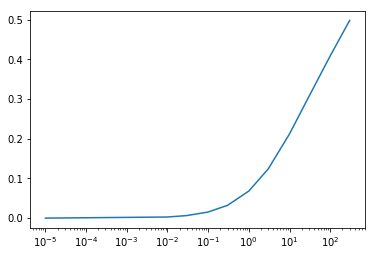

In [335]:
plt.plot(gammas, final_costs)
plt.xscale("log")

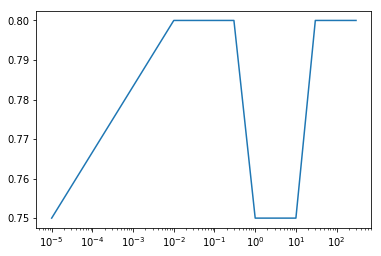

In [336]:
plt.plot(gammas, accs)
plt.xscale("log")

Next steps:

* Congressional voting records dataset? For high-dimensional problem!
* Neural net! (Code it up)
* Variable architecture (input size, layer size, number of layers etc etc)
* Stopping conditions - similar to in logistic reg (gets harder with stoch grad desc - think about this - cost on validation set? Stop when this starts rising.....)
* Stochastic gradient descent (rather than whole dataset) - single/minibatch
* NICE PICTURES :D decision boundaries? Examples where linear boundaries from LR don't work but NN does?
* Start writing it up!!!

